<a href="https://colab.research.google.com/github/RashikaNatharani/BCI-Classification/blob/master/robotic_grasp_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ROBOTIC GRASP DETECTION
## Based on 'Robotic Grasp Detection using Deep Convolutional Neural Networks' (Sulabh Kumra and Christopher Kanan, 2017)

In [ ]:
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import shapely.geometry

!pip install tensorflow==1.12
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

     |████████████████████████████████| 83.1MB 41kB/s 
     |████████████████████████████████| 3.1MB 33.4MB/s 
  Found existing installation: tensorboard 2.0.2
    Uninstalling tensorboard-2.0.2:
      Successfully uninstalled tensorboard-2.0.2
  Found existing installation: tensorflow 2.0.0
    Uninstalling tensorflow-2.0.0:
      Successfully uninstalled tensorflow-2.0.0


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import Callback

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
class RotatedRect:
    def __init__(self, rect):
        self.cx = rect[0]
        self.cy = rect[1]
        self.h = rect[2]
        self.w = rect[3]
        self.angle = rect[4]*180/math.pi

    def get_contour(self):
        w = self.w
        h = self.h
        c = shapely.geometry.box(-w/2.0, -h/2.0, w/2.0, h/2.0)
        rc = shapely.affinity.rotate(c, self.angle)
        return shapely.affinity.translate(rc, self.cx, self.cy)

    def intersection(self, other):
        return self.get_contour().intersection(other.get_contour())
    
    def union(self, other):
        return self.get_contour().union(other.get_contour())

In [ ]:
def rectangle_metrics(Y_true, Y_predict):
    theta_true = Y_true[:,4]
    theta_predict = Y_predict[:,4]
    
    diff = abs(theta_true-theta_predict)
    score = []
    for i in range(diff.shape[0]):
      if diff[i] > (30*math.pi/180):
        score.append(0)
      else:
        r1 = RotatedRect(Y_true[i,:])
        r2 = RotatedRect(Y_predict[i,:])
        jaccard_coeff = r1.intersection(r2).area/r1.union(r2).area
    
        if jaccard_coeff > 0.25:
          score.append(1)
        else:
          score.append(0)
        
    return np.sum(score)/np.shape(score)

    class RectangleMetrics(Callback):
    #def __init__(self):
        #self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs={}):
        X_val, Y_val_true = self.validation_data[0], self.validation_data[1]
        Y_val_predict = np.asarray(self.model.predict(X_val))
        score = self.calculate_score(Y_val_true, Y_val_predict)
        print('- acc: ', score)

    def calculate_score(self, Y_true, Y_predict):
        theta_true = Y_true[:,4]
        theta_predict = Y_predict[:,4]
        
        diff = abs(theta_true-theta_predict)
        score = []
        for i in range(diff.shape[0]):
          if diff[i] > (30*math.pi/180):
            score.append(0)
          else:
            r1 = RotatedRect(Y_true[i,:])
            r2 = RotatedRect(Y_predict[i,:])
            jaccard_coeff = r1.intersection(r2).area/r1.union(r2).area
        
            if jaccard_coeff > 0.25:
              score.append(1)
            else:
              score.append(0)
            
        return np.sum(score)/np.shape(score)
        def on_test_end(self, logs=None):
        Y_test_predict = np.asarray(self.model.predict(self.validation_data[0]))
        score = self.calculate_score(self.validation_data[1], Y_test_predict)
        print('- acc: ', score)

In [ ]:
def bbox_to_grasp(box):
    x = (box[0] + (box[4] - box[0])/2) 
    y = (box[1] + (box[5] - box[1])/2)
    h = math.sqrt(math.pow((box[6] - box[0]), 2) + math.pow((box[7] -box[1]), 2))
    w = math.sqrt(math.pow((box[2] - box[0]), 2) + math.pow((box[3] -box[1]), 2))
    theta = math.atan2(box[2] - box[0], box[3] - box[1])
    if theta < 0:
        theta += math.pi
    return x, y, h, w, theta

def adjust_bboxes(bboxes, ratio = 224/480):
    bboxes_cropped = []
    for i in range(len(bboxes)):
        if not i%2:
            bboxes_cropped.append(bboxes[i]-80)
        else:
            bboxes_cropped.append(bboxes[i])

    bboxes_scaled = [int(i*ratio) for i in bboxes_cropped]
    return bboxes_scaled

def draw_bbox(image, bbox):
    img = image.copy()
    cv2.line(img, (bbox[0],bbox[1]), (bbox[2],bbox[3]), (255, 0, 0))
    cv2.line(img, (bbox[2],bbox[3]), (bbox[4],bbox[5]), (0, 0, 255))
    cv2.line(img, (bbox[4],bbox[5]), (bbox[6],bbox[7]), (255, 0, 0))
    cv2.line(img, (bbox[6],bbox[7]), (bbox[0],bbox[1]), (0, 0, 255))
    return img
    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def draw_grasp(image, grasp):
    centre = [grasp[0],grasp[1]]
    height, width, theta = grasp[2], grasp[3], grasp[4]
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
    p1 = [ + height / 2,  + width / 2]
    p2 = [- height / 2,  + width / 2]
    p3 = [ - height / 2, - width / 2]
    p4 = [ + height / 2,  - width / 2]
    p1_new = np.dot(p1, R)+ centre
    p2_new = np.dot(p2, R)+ centre
    p3_new = np.dot(p3, R)+ centre
    p4_new = np.dot(p4, R)+ centre
    
    bbox = [p1_new, p2_new, p3_new, p4_new]
    bbox = np.array(bbox)
    bbox = bbox.reshape((1,8))[0].astype(int)
    return draw_bbox(image,bbox)

### Data loading and preprocessing
#### Five-fold cross validation (image-wise split)


In [ ]:
X_train_fold =	{0: [], 1: [], 2: [], 3: [], 4: []}
Y_train_fold =	{0: [], 1: [], 2: [], 3: [], 4: []}

X_test = []
Y_test = []

i = 0
for img_path in glob.glob("/content/drive/My Drive/diplomski/cornell_grasping_dataset/*.png"):
    img = cv2.imread(img_path)
    img = img[:,80:560,:] # crop to (480,480) in order to preserve aspect ratio when resizing
    img = cv2.resize(img,(224,224))
    
    bbox_path = img_path.split('.')[0][:-1]+'cpos.txt'
    with open(bbox_path, 'r') as f:
        bboxes_list = list(map(lambda coordinate: float(coordinate), f.read().strip().split()))
        bboxes = adjust_bboxes(bboxes_list)

    if not i%6:
        for j in range(int(len(bboxes)/8)):
            X_test.append(img)
            Y_test.append(bbox_to_grasp(bboxes[j*8:j*8+8]))
    else:
        for j in range(int(len(bboxes)/8)):
            X_train_fold[i%5].append(img)
            Y_train_fold[i%5].append(bbox_to_grasp(bboxes[j*8:j*8+8]))
    i += 1

    
for i in range(5):
  X_train_fold[i] = np.array(X_train_fold[i])
  Y_train_fold[i] = np.array(Y_train_fold[i])

X_test = np.array(X_test)
Y_test = np.array(Y_test)

#### Zapravo je ukupan broj slika u datasetu 885, ali je 5k označenih točnih pravokutnika

In [ ]:
train_images = 0
for x, y in X_train_fold.items():
  print("Fold {} contains {} images.\n".format(x, y.shape[0])) 
  train_images += y.shape[0]

print("There are {} train images and {} test images.".format(train_images, X_test.shape[0]))

Fold 0 contains 817 images.

Fold 1 contains 842 images.

Fold 2 contains 884 images.

Fold 3 contains 824 images.

Fold 4 contains 859 images.

There are 4226 train images and 884 test images.


Shape of each image in the training data:  (224, 224, 3)


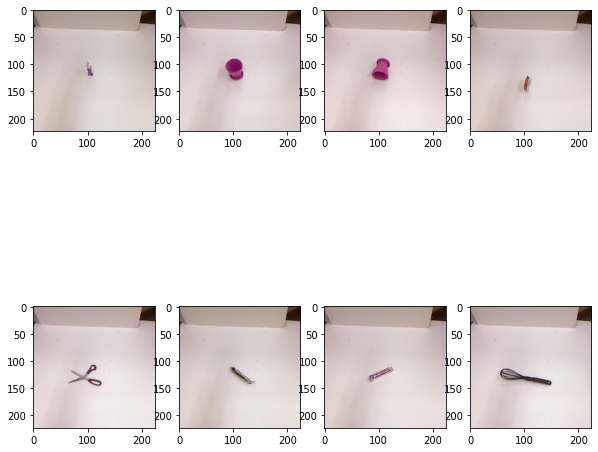

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(1, 9):
    img = X_train_fold[2][i*10]
    fig.add_subplot(2, 4, i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

print('Shape of each image in the training data: ', X_train_fold[1].shape[1:])

Grasp example


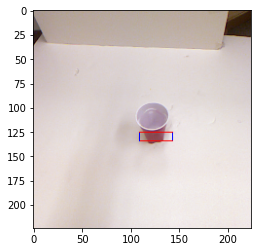

In [ ]:
img = X_train_fold[1][-1]
plt.imshow(cv2.cvtColor(draw_grasp(img,Y_train_fold[1][-1]), cv2.COLOR_BGR2RGB))
print('Grasp example')

### Model architecture

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
train_features_fold = {0: [], 1: [], 2: [], 3: [], 4: []}

for i in range(5):
  X_train_fold[i] = preprocess_input(X_train_fold[i])
  train_features_fold[i] = base_model.predict(X_train_fold[i])

X_test_pp = preprocess_input(X_test)
test_features = base_model.predict(X_test_pp)

In [ ]:
top_model = Sequential()
top_model.add(GlobalAveragePooling2D(input_shape=train_features_fold[1].shape[1:]))
top_model.add(Dense(1024, activation='relu', kernel_initializer="glorot_normal", bias_initializer="glorot_normal"))
top_model.add(Dropout(0.2))
top_model.add(Dense(5, activation='relu', kernel_initializer="glorot_normal", bias_initializer="glorot_normal"))

top_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 2,103,301
Trainable params: 2,103,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9)
top_model.compile(loss='mse', optimizer=sgd)

### Training and evaluation - top layers

In [ ]:
epochs = 30
for i in range(int(epochs/5)):
  for j in range(5):
    print('Epoch {}/{}'.format(i*5+j+1,epochs))
    top_model.fit(x = np.concatenate((train_features_fold[(j+1)%5], train_features_fold[(j+2)%5], train_features_fold[(j+3)%5], train_features_fold[(j+4)%5])), 
                  y = np.concatenate((Y_train_fold[(j+1)%5], Y_train_fold[(j+2)%5], Y_train_fold[(j+3)%5], Y_train_fold[(j+4)%5])),
                  batch_size=32, validation_data = (train_features_fold[j],Y_train_fold[j]), verbose=1, shuffle=True)

Epoch 1/30
Train on 3409 samples, validate on 817 samples
3409/3409 [==============================] - 2s 728us/sample - loss: 5488.9548 - val_loss: 5641.2873
Epoch 2/30
Train on 3384 samples, validate on 842 samples
3384/3384 [==============================] - 2s 501us/sample - loss: 5649.6758 - val_loss: 5621.8378
Epoch 3/30
Train on 3342 samples, validate on 884 samples
3342/3342 [==============================] - 2s 508us/sample - loss: 4693.8706 - val_loss: 28505.5722
Epoch 4/30
Train on 3402 samples, validate on 824 samples
3402/3402 [==============================] - 2s 501us/sample - loss: 3668.3905 - val_loss: 2467.5134
Epoch 5/30
Train on 3367 samples, validate on 859 samples
3367/3367 [==============================] - 2s 510us/sample - loss: 1503.0311 - val_loss: 290.2728
Epoch 6/30
Train on 3409 samples, validate on 817 samples
3409/3409 [==============================] - 2s 506us/sample - loss: 347.2031 - val_loss: 277.5061
Epoch 7/30
Train on 3384 samples, validate on 84

In [ ]:
print('Evaluate on test data')
results = top_model.evaluate(test_features, Y_test, batch_size=128)
print('test loss: ', results)

Y_predict = np.asarray(top_model.predict(test_features))
acc = rectangle_metrics(Y_test, Y_predict)
print('acc: ', acc)

Evaluate on test data
884/884 [==============================] - 0s 282us/sample - loss: 171.1833
test loss:  171.18326109458957
acc:  [0.09615385]


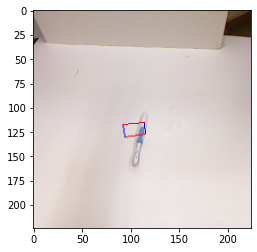

In [ ]:
y = top_model.predict(np.expand_dims(test_features[100],0))
plt.imshow(cv2.cvtColor(draw_grasp(X_test[100],y[0]), cv2.COLOR_BGR2RGB))

### Final model

In [ ]:
base_model.trainable = True
base_model_input = Input((224,224,3))
base_model_output = base_model(base_model_input)
top_model_output = top_model(base_model_output)

model = Model(base_model_input, top_model_output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
sequential (Sequential)      (None, 5)                 2103301   
Total params: 25,691,013
Trainable params: 25,637,893
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9)
model.compile(optimizer=sgd, loss='mse')

In [ ]:
epochs = 15
for i in range(int(epochs/5)):
  for j in range(5):
    print('Epoch {}/{}'.format(i*5+j+1,epochs))
    model.fit(x = np.concatenate((X_train_fold[(j+1)%5], X_train_fold[(j+2)%5], X_train_fold[(j+3)%5], X_train_fold[(j+4)%5])), 
              y = np.concatenate((Y_train_fold[(j+1)%5], Y_train_fold[(j+2)%5], Y_train_fold[(j+3)%5], Y_train_fold[(j+4)%5])),
              batch_size=32, validation_data = (X_train_fold[j],Y_train_fold[j]), verbose=1, shuffle=True)

Epoch 1/15
Train on 3409 samples, validate on 817 samples
3409/3409 [==============================] - 1775s 521ms/sample - loss: 123.0722 - val_loss: 137.2209
Epoch 2/15
Train on 3384 samples, validate on 842 samples
3384/3384 [==============================] - 1779s 526ms/sample - loss: 101.5061 - val_loss: 97.1395
Epoch 3/15
Train on 3342 samples, validate on 884 samples
3342/3342 [==============================] - 1739s 520ms/sample - loss: 84.0916 - val_loss: 90.9909
Epoch 4/15
Train on 3402 samples, validate on 824 samples
3402/3402 [==============================] - 1762s 518ms/sample - loss: 75.3818 - val_loss: 73.1711
Epoch 5/15
Train on 3367 samples, validate on 859 samples
3367/3367 [==============================] - 1762s 523ms/sample - loss: 70.9136 - val_loss: 63.3217
Epoch 6/15
Train on 3409 samples, validate on 817 samples
3409/3409 [==============================] - 1769s 519ms/sample - loss: 67.2233 - val_loss: 63.2421
Epoch 7/15
Train on 3384 samples, validate on 842

In [ ]:
print('Evaluate on test data')
results = model.evaluate(X_test_pp, Y_test, batch_size=128)
print('test loss: ', results)

Y_predict = np.asarray(model.predict(X_test_pp))
acc = rectangle_metrics(Y_test, Y_predict)
print('acc: ', acc)

Evaluate on test data
884/884 [==============================] - 105s 119ms/sample - loss: 70.6255
test loss:  70.62550229724177
acc:  [0.24321267]


In [ ]:
Y_predict[0:15]

array([[105.0742   , 107.18879  ,  12.595275 ,  24.891617 ,   1.7277519],
       [105.0742   , 107.18879  ,  12.595275 ,  24.891617 ,   1.7277519],
       [105.0742   , 107.18879  ,  12.595275 ,  24.891617 ,   1.7277519],
       [105.0742   , 107.18879  ,  12.595275 ,  24.891617 ,   1.7277519],
       [105.0742   , 107.18879  ,  12.595275 ,  24.891617 ,   1.7277519],
       [105.0742   , 107.18879  ,  12.595275 ,  24.891617 ,   1.7277519],
       [105.0742   , 107.18879  ,  12.595275 ,  24.891617 ,   1.7277519],
       [ 98.310005 , 132.33284  ,  12.13235  ,  23.014858 ,   1.6803311],
       [ 98.310005 , 132.33284  ,  12.13235  ,  23.014858 ,   1.6803311],
       [ 98.310005 , 132.33284  ,  12.13235  ,  23.014858 ,   1.6803311],
       [ 98.310005 , 132.33284  ,  12.13235  ,  23.014858 ,   1.6803311],
       [ 97.65993  , 125.74731  ,  11.56426  ,  20.799456 ,   1.6552552],
       [ 97.65993  , 125.74731  ,  11.56426  ,  20.799456 ,   1.6552552],
       [ 97.65993  , 125.74731  ,  11.

[[109.028694  134.43971    12.505005   23.25578     1.7411003]]


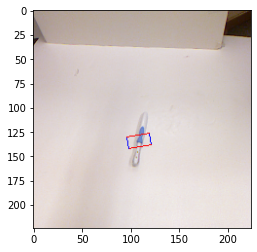

In [ ]:
img_expanded = np.expand_dims(X_test_pp[100], 0)
y = model.predict(img_expanded)
print (y)
plt.imshow(cv2.cvtColor(draw_grasp(X_test[100],y[0]), cv2.COLOR_BGR2RGB))

In [ ]:
os.makedirs('./drive/My Drive/diplomski/model', exist_ok=True)
model.save('./drive/My Drive/diplomski/model/grasp_model.h5')